In [38]:

# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)

Running on device: CUDA


In [39]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [40]:


import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset

In [41]:
sch = 'linear'
init_rate = 0.3
init_method = 'snip_little_grad'
lr = 0.001
epoch = 5
weight_decay = 5e-4

from torch.optim.lr_scheduler import _LRScheduler

class LinearAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, num_annealing_steps, num_total_steps):
        self.num_annealing_steps = num_annealing_steps
        self.num_total_steps = num_total_steps

        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_annealing_steps:
            return [base_lr * self._step_count / self.num_annealing_steps for base_lr in self.base_lrs]
        else:
            return [base_lr * (self.num_total_steps - self._step_count) / (self.num_total_steps - self.num_annealing_steps) for base_lr in self.base_lrs]


def set_layer(model, layer_name, layer):
    splited = layer_name.split('.')
    if len(splited) == 1:
        setattr(model, splited[0], layer)
    elif len(splited) == 3:
        setattr(getattr(model, splited[0])[int(splited[1])], splited[2], layer)
    elif len(splited) == 4:
        getattr(getattr(model, splited[0])[int(splited[1])], splited[2])[int(splited[3])] = layer

class Masker(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, mask):
        ctx.save_for_backward(mask)
        return x

    @staticmethod
    def backward(ctx, grad):
        mask, = ctx.saved_tensors
        return grad * mask, None

class MaskConv2d(nn.Conv2d):
    def __init__(self, mask, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device='cpu'):
        super(MaskConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                     padding, dilation, groups, bias, padding_mode, device=device)
        self.mask = mask

    def forward(self, input):
        masked_weight = Masker.apply(self.weight, self.mask)
        return super(MaskConv2d, self)._conv_forward(input, masked_weight, self.bias)

@torch.no_grad()
def replace_maskconv(model):
    print("Remove Maskconv")
    for name, m in list(model.named_modules()):
        if isinstance(m, MaskConv2d):
            conv = nn.Conv2d(m.in_channels, m.out_channels, m.kernel_size, m.stride,
                 m.padding, m.dilation, m.groups, m.bias!=None, m.padding_mode, device=DEVICE)
            conv.weight.data = m.weight
            conv.bias = m.bias
            set_layer(model, name, conv)

def get_grads_for_snip(model, retain_loader, forget_loader):
    indices = torch.randperm(len(retain_loader.dataset), dtype=torch.int32, device='cpu')[:len(forget_loader.dataset)]
    retain_dataset = torch.utils.data.Subset(retain_loader.dataset, indices)
    retain_loader = DataLoader(retain_dataset, batch_size=64, shuffle=True)

    model.zero_grad()
    for sample in retain_loader:
        inputs = sample[0]
        targets = sample[1]
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()

    for sample in forget_loader:
        inputs = sample[0]
        targets = sample[1]
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        outputs = model(inputs)
        loss = -F.cross_entropy(outputs, targets)
        loss.backward()

@torch.no_grad()
def re_init_model_snip_ver2_little_grad(model, px): # re init smallest gradients
    print("Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)")
    for name, m in list(model.named_modules()):
        if isinstance(m, nn.Conv2d):
            mask = torch.zeros_like(m.weight, device=DEVICE).bool()
            nparams_toprune = round(px*mask.nelement())

            out_c, in_c, ke, _ = mask.shape
            value = -m.weight.grad.abs()
            topk = torch.topk(value.view(-1), k=nparams_toprune)
            mask.view(-1)[topk.indices] = True
            grad_mask = mask.clone().float()
            grad_mask[grad_mask==0] += 0.1

            new_conv = MaskConv2d(grad_mask, m.in_channels, m.out_channels, m.kernel_size, m.stride,
                 m.padding, m.dilation, m.groups, m.bias!=None, m.padding_mode, device=DEVICE)
            nn.init.kaiming_normal_(new_conv.weight, mode="fan_out", nonlinearity="relu")

            new_conv.weight.data[~mask] = m.weight[~mask]

            set_layer(model, name, new_conv)


def unlearning(
    net,
    retain_loader,
    forget_loader,
    val_loader):
    if init_method=='snip_little_grad':
        # replace_maskconv(net)
        get_grads_for_snip(net, retain_loader, forget_loader)
        re_init_model_snip_ver2_little_grad(net, init_rate)

    """Simple unlearning by finetuning."""
    epochs = epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=weight_decay)

    if sch=='linear':
        scheduler = LinearAnnealingLR(optimizer, num_annealing_steps=(epochs+1)//2, num_total_steps=epochs+1)
    net.train()

    for ep in range(epochs):
        for sample in retain_loader:
            inputs = sample[0]
            targets = sample[1]
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

        scheduler.step()
    #remove_prune(net)
    net.eval()
    return net


In [42]:
from sklearn.linear_model import LogisticRegression

def train_mia_on_class(model, class_index, train_set, test_set, no_class=True, splits_num=5):
  model = model.to("cpu")

  if not no_class:
    # Select indencies where class is class_index
    train_class_set = np.where(np.array(train_set.targets) == class_index)[0]
    test_class_set = np.where(np.array(test_set.targets) == class_index)[0]
  else:
    train_class_set = np.arange(len(train_set))
    test_class_set = np.arange(len(test_set))

  max_len = min([len(train_class_set), len(test_class_set)])
  # Make equal sizes
  train_class_set = train_class_set[:max_len]
  test_class_set = test_class_set[:max_len]

  # Obtain subsets
  train_class_set = torch.utils.data.Subset(train_set, train_class_set)
  test_class_set = torch.utils.data.Subset(test_set, test_class_set)


  # Make them
  class_test_loader = torch.utils.data.DataLoader(
    test_class_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )

  class_train_loader = torch.utils.data.DataLoader(
    train_class_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )

  criterion = nn.CrossEntropyLoss(reduction="none")
  # Obtain train and test logits
  logits_train = []
  for i, (images, labels) in enumerate(class_train_loader, 0):
    for img, label in zip(images, labels):
      logits = model(img.unsqueeze(0))
      losses = criterion(logits, label.unsqueeze(0)).numpy(force=True)

      logits_train.append(np.concatenate((logits.detach().numpy()[0], losses)))

  logits_test = []
  for i, (images, labels) in enumerate(class_test_loader, 0):
    for img, label in zip(images, labels):
      logits = model(img.unsqueeze(0))
      losses = criterion(logits, label.unsqueeze(0)).numpy(force=True)

      logits_test.append((np.concatenate((logits.detach().numpy()[0], losses))))

  logits_train, logits_test = np.array(logits_train), np.array(logits_test)
  # Create dataset
  ys = [1] * max_len + [0] * max_len
  ys = np.array(ys)
  p = np.random.permutation(len(ys))
  logits = np.concatenate((logits_train, logits_test))

  logits = logits[p]
  ys = ys[p]

  # Fit logitstic regression
  clf = LogisticRegression(random_state=0, max_iter=1000)
  cv = model_selection.StratifiedShuffleSplit(
        n_splits=splits_num, random_state=0
    )

  clf = model_selection.cross_val_score(
        clf, logits, ys, cv=cv, scoring="accuracy"
    )

  # Output score
  # print(f"Mean MIA attack score for class {class_index} is: " + str(clf.mean()))
  return clf.mean()


In [43]:


# Check accuracy

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


In [44]:

def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

## Перевірка взаємозалежності між кількістю даних для Forget set і результатом алгоритму

In [45]:
print("----- 1 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.01

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- 1 PERCENT -------
Model name: Resnet18 Baseline
Amount: 1.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 94.0
MIA score before on forget set: 0.95


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.9%
Test set accuracy FORGET model: 69.1%
Forget set accuracy FORGET model: 76.0%

The MIA has an accuracy of 0.840 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 96.0
MIA score before on forget set: 0.95


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.6%
Test set accuracy FORGET model: 69.1%
Forget set accuracy FORGET model: 86.0%

The MIA has an accuracy of 0.960 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 94.0
MIA score before on forget set: 0.9


Appl

In [46]:

mean_mia_score_before_1p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_1p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_1p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_1p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_1p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_1p = np.mean(np.array(Accuracy_test))


In [47]:
print(mean_mia_score_before_1p)
print(mean_mia_score_after_1p)

print(mean_accuracy_forget_before_1p)

print(mean_accuracy_forget_after_1p)
print(mean_accuracy_retain_1p)
print(mean_accuracy_test_1p)

0.8800000000000001
0.8640000000000001
92.4
74.0
78.72552552552553
69.136


In [48]:
print("----- 2 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.02

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  model_forget_ft.eval()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)

----- 2 PERCENT -------
Model name: Resnet18 Baseline
Amount: 2.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 100.0
MIA score before on forget set: 0.875


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 79.2%
Test set accuracy FORGET model: 69.8%
Forget set accuracy FORGET model: 84.0%

The MIA has an accuracy of 0.890 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 96.0
MIA score before on forget set: 0.925


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.7%
Test set accuracy FORGET model: 68.8%
Forget set accuracy FORGET model: 87.0%

The MIA has an accuracy of 0.900 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 94.0
MIA score before on forget set: 0.925



In [49]:
mean_mia_score_before_2p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_2p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_2p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_2p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_2p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_2p = np.mean(np.array(Accuracy_test))


In [50]:
print(mean_mia_score_before_2p)
print(mean_mia_score_after_2p)

print(mean_accuracy_forget_before_2p)

print(mean_accuracy_forget_after_2p)
print(mean_accuracy_retain_2p)
print(mean_accuracy_test_2p)

0.9075000000000001
0.849
95.1
78.8
78.90186707281546
69.213


In [51]:
print("----- 5 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.05

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)


----- 5 PERCENT -------
Model name: Resnet18 Baseline
Amount: 5.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 96.39999999999999
MIA score before on forget set: 0.91


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.5%
Test set accuracy FORGET model: 69.2%
Forget set accuracy FORGET model: 78.4%

The MIA has an accuracy of 0.852 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 96.0
MIA score before on forget set: 0.95


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.3%
Test set accuracy FORGET model: 68.8%
Forget set accuracy FORGET model: 86.4%

The MIA has an accuracy of 0.932 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 92.4
MIA score before on forget se

In [52]:

mean_mia_score_before_5p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_5p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_5p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_5p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_5p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_5p = np.mean(np.array(Accuracy_test))

In [53]:
print(mean_mia_score_before_5p)
print(mean_mia_score_after_5p)

print(mean_accuracy_forget_before_5p)

print(mean_accuracy_forget_after_5p)
print(mean_accuracy_retain_5p)
print(mean_accuracy_test_5p)

0.916
0.8708
94.36
77.8
78.60049364235951
69.122


In [54]:
print("----- 10 PERCENT -------")
# Generalisation algorithm
# Calculating score across 10 different classes
# Model parameters
model_name = "Resnet18 Baseline"
model_params = "cifar10_resnet18_baseline.pt"

# Percantage of class to forget
amount = 0.1

# Show different classes
classes = np.unique(np.array(train_set.targets))

# mia scores
MIA_scores_before = []
MIA_scores = []

# Accuracy
Accuracy_forget_before = []

Accuracy_retain = []
Accuracy_forget = []
Accuracy_test = []


print(f"Model name: {model_name}")
print(f"Amount: {100 * amount}")

for class_num in classes:
  print(f"------ UNLEARNING CLASS {class_num} ------\n")
  # Define model from trained params

  model_forget_ft = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
  model_forget_ft.load_state_dict(torch.load(model_params))
  model_forget_ft.eval()
  model_forget_ft = model_forget_ft.to(DEVICE)

  # --- FORMING DATASET ------
  # Choose random forget indecies from some class
  # Index of class
  class_index = class_num # cars
  class_set = np.where(np.array(train_set.targets) == class_num)[0]

  # Percantage of whole data ( from class )
  amount_int = class_set.shape[0] * amount

  # Get indeces
  forget_idx = np.random.choice(class_set, int(amount_int))

  # construct indices of retain from those of the forget set
  forget_mask = np.zeros(len(train_set.targets), dtype=bool)
  forget_mask[forget_idx] = True
  retain_idx = np.arange(forget_mask.size)[~forget_mask]

  # split train set into a forget and a retain set
  forget_set = torch.utils.data.Subset(train_set, forget_idx)
  retain_set = torch.utils.data.Subset(train_set, retain_idx)

  # Generate forget and retain loaders
  forget_loader = torch.utils.data.DataLoader(
      forget_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  retain_loader = torch.utils.data.DataLoader(
      retain_set, batch_size=256, shuffle=True, num_workers=2, generator=RNG
  )
  # ---------

  # --- EVALUATING MODEL BEFORE ----
  accuracy_forget = 100.0 * accuracy(model_forget_ft, forget_loader)
  Accuracy_forget_before.append(accuracy_forget)
  print(f"Accuracy before on forget set: {accuracy_forget}")

  mia_attack = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 2)
  MIA_scores_before.append(mia_attack)
  print(f"MIA score before on forget set: {np.round(mia_attack, 3)}")
  print("\n")

  model_forget_ft = model_forget_ft.to(DEVICE)
  # --------------

  # Unlearn
  model_ft_forget = unlearning(model_forget_ft, retain_loader, forget_loader, test_loader)

  # Compare accuracy
  print(f"Retain set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, retain_loader):0.1f}%")
  print(f"Test set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, test_loader):0.1f}%")
  print(f"Forget set accuracy FORGET model: {100.0 * accuracy(model_ft_forget, forget_loader):0.1f}%")

  Accuracy_retain.append(100.0 * accuracy(model_ft_forget, retain_loader))
  Accuracy_forget.append(100.0 * accuracy(model_ft_forget, forget_loader))
  Accuracy_test.append(100.0 * accuracy(model_ft_forget, test_loader))
  print()
  mia_scores_fr = train_mia_on_class(model_forget_ft, class_num, forget_set, test_set, True, 5)
  MIA_scores.append(mia_scores_fr)
  print(
      f"The MIA has an accuracy of {mia_scores_fr:.3f} on forgotten vs unseen images on FORGET model"
  )
  print()
  print('-' * 20)


----- 10 PERCENT -------
Model name: Resnet18 Baseline
Amount: 10.0
------ UNLEARNING CLASS 0 ------

Accuracy before on forget set: 96.6
MIA score before on forget set: 0.95


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.4%
Test set accuracy FORGET model: 68.8%
Forget set accuracy FORGET model: 81.8%

The MIA has an accuracy of 0.874 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 1 ------

Accuracy before on forget set: 96.0
MIA score before on forget set: 0.91


Apply Unstructured re_init_model_snip_ver2_little_grad Globally (all conv layers)
Retain set accuracy FORGET model: 78.5%
Test set accuracy FORGET model: 69.1%
Forget set accuracy FORGET model: 85.2%

The MIA has an accuracy of 0.928 on forgotten vs unseen images on FORGET model

--------------------
------ UNLEARNING CLASS 2 ------

Accuracy before on forget set: 90.60000000000001
MIA score before on forget 

In [55]:
mean_mia_score_before_10p = np.mean(np.array(MIA_scores_before))
mean_mia_score_after_10p = np.mean(np.array(MIA_scores))

mean_accuracy_forget_before_10p = np.mean(np.array(Accuracy_forget_before))

mean_accuracy_forget_after_10p = np.mean(np.array(Accuracy_forget))
mean_accuracy_retain_10p = np.mean(np.array(Accuracy_retain))
mean_accuracy_test_10p = np.mean(np.array(Accuracy_test))

In [56]:
print(mean_mia_score_before_10p)
print(mean_mia_score_after_10p)

print(mean_accuracy_forget_before_10p)

print(mean_accuracy_forget_after_10p)
print(mean_accuracy_retain_10p)
print(mean_accuracy_test_10p)

0.9174999999999999
0.8667999999999999
93.48
76.70000000000002
78.76058352590857
69.30300000000001


In [57]:
mean_mia_before = [mean_mia_score_before_1p, mean_mia_score_before_2p, mean_mia_score_before_5p, mean_mia_score_before_10p]
mean_mia_after = [mean_mia_score_after_1p, mean_mia_score_after_2p, mean_mia_score_after_5p, mean_mia_score_after_10p]

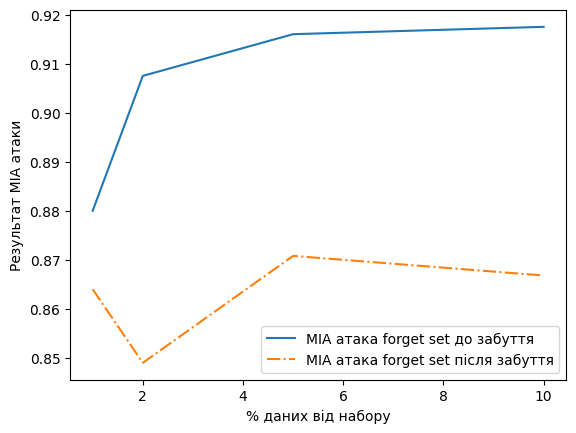

In [58]:

import matplotlib.pyplot as plt

x = [1, 2, 5, 10]

plt.plot(x, mean_mia_before, label ='MIA атака forget set до забуття')
plt.plot(x, mean_mia_after, '-.', label ='MIA атака forget set після забуття')

plt.xlabel("% даних від набору")
plt.ylabel("Результат MIA атаки")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [59]:
mean_accuracy_before = [mean_accuracy_forget_before_1p, mean_accuracy_forget_before_2p, mean_accuracy_forget_before_5p, mean_accuracy_forget_before_10p]
mean_accuracy_after = [mean_accuracy_forget_after_1p, mean_accuracy_forget_after_2p, mean_accuracy_forget_after_5p, mean_accuracy_forget_after_10p]



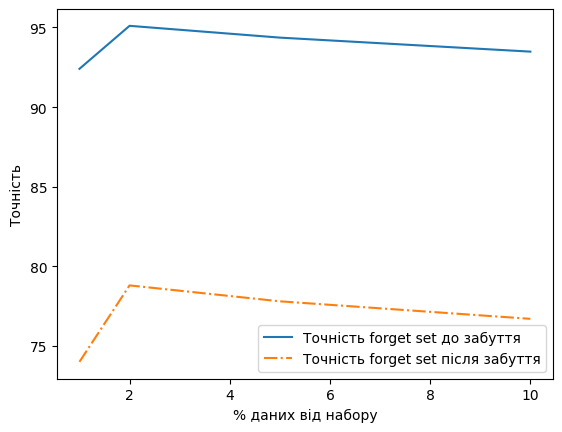

In [60]:

import matplotlib.pyplot as plt

x = [1, 2, 5, 10]

plt.plot(x, mean_accuracy_before, label ='Точність forget set до забуття')
plt.plot(x, mean_accuracy_after, '-.', label ='Точність forget set після забуття')

plt.xlabel("% даних від набору")
plt.ylabel("Точність")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [61]:
mean_accuracy_retain = [mean_accuracy_retain_1p, mean_accuracy_retain_2p, mean_accuracy_retain_5p, mean_accuracy_retain_10p]
mean_accuracy_test = [mean_accuracy_test_1p, mean_accuracy_test_2p, mean_accuracy_test_5p, mean_accuracy_test_10p]



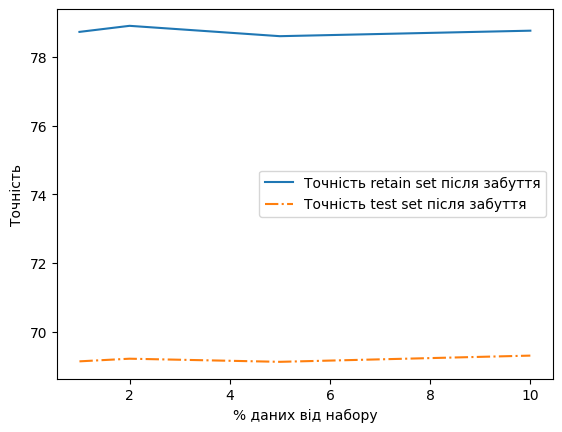

In [62]:
import matplotlib.pyplot as plt

x = [1, 2, 5, 10]

plt.plot(x, mean_accuracy_retain, label ='Точність retain set після забуття')
plt.plot(x, mean_accuracy_test, '-.', label ='Точність test set після забуття')

plt.xlabel("% даних від набору")
plt.ylabel("Точність")
plt.legend()
# plt.title('multiple plots')
plt.show()

